In [1]:
from ipynb.fs.full.BreastFunctions import *
#from BreastFunctions_py import *
import numpy as np
import pandas as pd

In [55]:
# Prepare this dataframe (total results) only once

# Only load if needed to load total results from previous runs to continue on
total_results_dataframe_SVM = pd.read_csv("total_breastCancer_results_SVM.csv")
total_results_dataframe_KNN = pd.read_csv("total_breastCancer_results_KNN.csv")

# Prepare this dataframe (total results) only once
# total_results_dataframe_SVM = pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , "Predicted Metastasis" ,
# "Metastasis Status", "Number of Clusters" , "SAM Features for each tSNE run on new subset"])

# total_results_dataframe_KNN= pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , "Predicted Metastasis" ,
# "Metastasis Status", "Number of Clusters" , "SAM Features for each tSNE run on new subset"])



In [11]:
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data, sample_only_scaled_data , sample_ID_pixels = ReadBreastData()

In [12]:
## Selecting Patient as test
testPatient_ID = 1
#-------------------------------------------------------

train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_only_scaled_data = sample_only_scaled_data,
        sample_ID_pixels = sample_ID_pixels )


In [144]:
tsne_results = tSNE(train_scaled_data)
np.save("patient_TSNE/BreastCancer_tSNE_Model_Patient_{}".format(testPatient_ID) , tsne_results)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 46718 samples in 0.005s...
[t-SNE] Computed neighbors for 46718 samples in 50.746s...
[t-SNE] Computed conditional probabilities for sample 1000 / 46718
[t-SNE] Computed conditional probabilities for sample 2000 / 46718
[t-SNE] Computed conditional probabilities for sample 3000 / 46718
[t-SNE] Computed conditional probabilities for sample 4000 / 46718
[t-SNE] Computed conditional probabilities for sample 5000 / 46718
[t-SNE] Computed conditional probabilities for sample 6000 / 46718
[t-SNE] Computed conditional probabilities for sample 7000 / 46718
[t-SNE] Computed conditional probabilities for sample 8000 / 46718
[t-SNE] Computed conditional probabilities for sample 9000 / 46718
[t-SNE] Computed conditional probabilities for sample 10000 / 46718
[t-SNE] Computed conditional probabilities for sample 11000 / 46718
[t-SNE] Computed conditional probabilities for sample 12000 / 46718
[t-SNE] Computed conditional probabilities for s

In [13]:
tsne_results = np.load("patient_TSNE/BreastCancer_tSNE_Model_Patient_{}.npy".format(testPatient_ID))

In [14]:
kmeans_8 , kmeans_7, kmeans_6, kmeans_5 = KMeans_results(tsne_results)

In [15]:
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx","Breast Cancer Clinical Data")

NonMetastasis: [1. 2. 5. 3. 1. 2. 0. 3.]
Metastasis: [ 4.  4.  2.  5.  3.  1. 10.  5.]


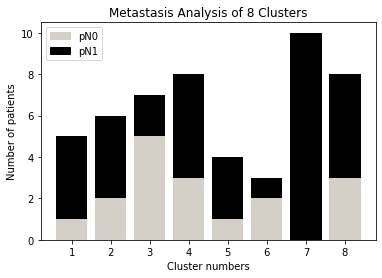

NonMetastasis: [2. 3. 1. 2. 1. 1. 5.]
Metastasis: [8. 5. 3. 1. 9. 6. 3.]


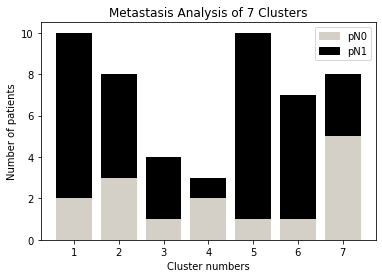

NonMetastasis: [3. 2. 5. 1. 2. 1.]
Metastasis: [5. 8. 4. 5. 1. 5.]


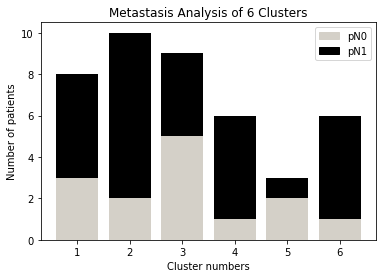

NonMetastasis: [2. 4. 2. 3. 1.]
Metastasis: [8. 4. 5. 2. 6.]


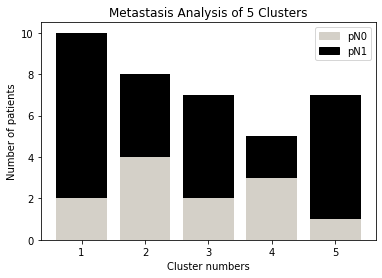

In [16]:
# Returns Non-Metastasis and Metastasis clusters
state08, state18 = metastasis_status(kmeans_8.labels_, Clinical_data,train_ID_pixels)
state07, state17 = metastasis_status(kmeans_7.labels_, Clinical_data,train_ID_pixels)
state06, state16 = metastasis_status(kmeans_6.labels_, Clinical_data,train_ID_pixels)
state05, state15 = metastasis_status(kmeans_5.labels_, Clinical_data,train_ID_pixels)

# Plots bar plot of Non-Metastasis and Metastasis clusters
plot_metastasis_status(state08, state18)
plot_metastasis_status(state07, state17)
plot_metastasis_status(state06, state16)
plot_metastasis_status(state05, state15)

# Create dict to save kmeans results and select them later
kmeans_dict = {"8_Clusters": [kmeans_8.labels_,state08] , "7_Clusters": [kmeans_7.labels_,state07]  , "6_Clusters": [kmeans_6.labels_,state06] , "5_Clusters": [kmeans_5.labels_,state05] }

In [17]:
# Select the correct kmeans that shows best results from metastasis analysis, must have one fully metastasis cluster
selected_clusters_value = 8

# ----------------------------------------------------------------------------------

# Detect the fully metastasis cluster, select the correct kmeans that shows best results from metastasis analysis
labels = kmeans_dict[str(selected_clusters_value)+"_Clusters"][0]
selected_state = kmeans_dict[str(selected_clusters_value)+"_Clusters"][1]

fully_metastasis_cluster_label = 0
for cluster in selected_state:
    if not cluster: # Cluster list is empty, has no healthy patients, so it's fully metastasis cluster
        break # fully_metastasis_cluster_label now has the right label, exit loop
    
    fully_metastasis_cluster_label += 1

print("Fully metastasis cluster label's index is {} and it is cluster {}".format(fully_metastasis_cluster_label,fully_metastasis_cluster_label+1))

Fully metastasis cluster label's index is 6 and it is cluster 7


In [23]:
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, fully_metastasis_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("BreastCancerAverageSpectrumValues.csv",index=False)

# Run R file in order to generate significant proteins using the csv file

In [32]:
#Need to read significant protein file outputted from R

SAM_protein = readSignificantProteins("significant_breast_proteins.json",delete=False)
SAM_protein = SAM_protein + readSignificantProteins("significant_breast_proteins_up.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, fully_metastasis_cluster_label)

In [33]:
SAM_protein

[6650, 4999, 6277, 11652]

In [34]:
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 0.1 , train_scaled_selected_proteins_data , train_labels , test_scaled_selected_proteins_data)

In [35]:
Metastasis_prob, Non_Metastasis_prob = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Metastasis_prob , Non_Metastasis_prob]

Metastasis probability : 64.54849498327759 
Non-Metastasis probability : 35.45150501672241


In [36]:
y_pred_KNN = KNN(5 , train_scaled_selected_proteins_data, train_labels, test_scaled_selected_proteins_data)

In [37]:
Metastasis_prob, Non_Metastasis_prob = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Metastasis_prob , Non_Metastasis_prob]

Metastasis probability : 65.55183946488295 
Non-Metastasis probability : 34.448160535117054


In [38]:
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_SVM
Metastasis_prob = Selected_model[0]
Non_Metastasis_prob = Selected_model[1]

In [46]:
# Run after model complete to save the result in the total results dataframe
total_results_dataframe_SVM = OutputDataframe(total_results_dataframe, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, selected_clusters_value, SAM_protein)

In [47]:
total_results_dataframe_SVM

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Predicted Metastasis,Metastasis Status,Number of Clusters,SAM Features for each tSNE run on new subset
0,1,54.329246,45.670754,2,1,8,"Significant Features : m/z = [6650, 4999, 6277..."
1,2,99.824356,0.175644,1,1,8,"Significant Features : m/z = [4965, 4999, 5171..."
2,3,36.860215,63.139785,2,1,6,"Significant Features : m/z = [6650, 6277, 6980..."
3,4,87.548638,12.451362,2,1,5,"Significant Features : m/z = [11310, 6980, 7009]"
4,5,97.392230,2.607770,2,1,8,"Significant Features : m/z = [4999, 4965, 5171..."
5,6,61.614173,38.385827,2,1,8,"Significant Features : m/z = [6277, 11652, 665..."
6,7,82.867384,17.132616,2,1,6,"Significant Features : m/z = [6650, 6277, 1165..."
7,8,32.474227,67.525773,2,1,5,"Significant Features : m/z = [6650, 6277, 4965..."
8,9,83.183569,16.816431,2,1,8,"Significant Features : m/z = [11652, 6650, 627..."
9,10,68.213573,31.786427,2,1,8,"Significant Features : m/z = [6277, 6650, 1165..."


In [49]:
total_results_dataframe_SVM.to_csv("total_breastCancer_results_SVM.csv" , index = False)

In [50]:
Selected_model = Surv_KNN
Metastasis_prob = Selected_model[0]
Non_Metastasis_prob = Selected_model[1]

In [51]:
total_results_dataframe_KNN = OutputDataframe(total_results_dataframe_KNN, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, selected_clusters_value, SAM_protein)

In [52]:
total_results_dataframe_KNN

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Predicted Metastasis,Metastasis Status,Number of Clusters,SAM Features for each tSNE run on new subset
0,1,34.448161,65.551839,2,1,8,"Significant Features : m/z = [6650, 4999, 6277..."
0,1,34.448161,65.551839,2,1,8,"Significant Features : m/z = [6650, 4999, 6277..."


In [54]:
total_results_dataframe_KNN.to_csv("total_breastCancer_results_KNN.csv" , index = False)